<a href="https://colab.research.google.com/github/Ashish0898/Automatic-Ticket-Classification/blob/Dev/Automatic_Ticket_Classification_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Cloning the DataSet from Github repo

In [1]:
# Cloning Github Repo to fetch JSON file
import os
import shutil

if os.path.exists('/content/Automatic-Ticket-Classification'):
  shutil.rmtree('/content/Automatic-Ticket-Classification')
  os.remove('/content/complaints-2021-05-14_08_16.json')
  
! git clone 'https://github.com/Ashish0898/Automatic-Ticket-Classification'

Cloning into 'Automatic-Ticket-Classification'...
remote: Enumerating objects: 42, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 42 (delta 20), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (42/42), 14.57 MiB | 10.61 MiB/s, done.


In [2]:

# Unzipping the file which contains JSON
!unzip /content/Automatic-Ticket-Classification/complaints-2021-05-14_08_16.zip

Archive:  /content/Automatic-Ticket-Classification/complaints-2021-05-14_08_16.zip
  inflating: complaints-2021-05-14_08_16.json  


## Importing the necessary libraries

In [3]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from pprint import pprint

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from wordcloud import WordCloud, STOPWORDS


from nltk.stem import WordNetLemmatizer
from textblob import TextBlob, Word
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [4]:
# Opening JSON file 
with open('/content/complaints-2021-05-14_08_16.json', 'r') as file:
    data = json.load(file)

# returns JSON object as  
# a dictionary 

df = pd.json_normalize(data)

## Debugging

In [5]:
text = "Thisisatextwithoutspaces"
#pattern = r"\b\w+\b"  # regex pattern to match one or more word characters

pattern = r'^\S+$'

xyz=df.copy()
xyz['_source.complaint_what_happened']=xyz['_source.complaint_what_happened'].replace('',np.nan,regex=True)
#xyz['_source.complaint_what_happened']=xyz['_source.complaint_what_happened'].replace('',np.nan,regex=True)
xyz.dropna(subset=['_source.complaint_what_happened'],inplace=True)


# use regex to filter rows with sample text with no spaces
xyz = xyz[~xyz['_source.complaint_what_happened'].str.contains(pattern)]
xyz.head()
# print the resulting dataframe
#xyz.head()


# for i in xyz['_source.complaint_what_happened']:
#   matches = re.search(pattern, i)
#   print(matches)
  # if(matches== True):
  #   xyz = xyz.drop(xyz[xyz['_source.complaint_what_happened'] == i].index, inplace=True)

#df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,Chase Card was reported on XX/XX/2019. However...,Information belongs to someone else,Consent provided
11,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"On XX/XX/2018, while trying to book a XXXX XX...",Information belongs to someone else,Consent provided
14,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for {$1600.00} i de...,Funds not handled or disbursed as instructed,Consent provided


In [6]:
# pattern=r'\b\w+\b'
# for i in df['_source.complaint_what_happened']:
#   matches = re.findall(pattern, i)
#   if(matches):
#     print(matches)
#     #df = df.drop(df[df['_source.complaint_what_happened'] == i].index, inplace=True)

In [7]:
#pd.set_option('display.max_colwidth', None)
#pd.set_option('display.max_rows', None)


xyz.head()
#print(xyz[xyz['_source.complaint_id']=='3417346']['_source.complaint_what_happened'])
print(xyz[xyz['_source.complaint_id']=='3417346']['_source.complaint_what_happened'])

print(xyz.loc[7677])

#pd.reset_option('display.max_colwidth')
#pd.reset_option('display.max_rows')


7677    IreceivedanemailXX/XX/XXXXthatmycreditcardswer...
Name: _source.complaint_what_happened, dtype: object
_index                                                             complaint-public-v2
_type                                                                        complaint
_id                                                                            3417346
_score                                                                             0.0
_source.tags                                                                      None
_source.zip_code                                                                 928XX
_source.complaint_id                                                           3417346
_source.issue                                                     Closing your account
_source.date_received                                        2019-10-24T12:00:00-05:00
_source.state                                                                       CA
_source.consumer_di

In [8]:
print(len(xyz),len(df))
xyz.head()


21069 78313


,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,Chase Card was reported on XX/XX/2019. However...,Information belongs to someone else,Consent provided
11,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"On XX/XX/2018, while trying to book a XXXX XX...",Information belongs to someone else,Consent provided
14,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for {$1600.00} i de...,Funds not handled or disbursed as instructed,Consent provided


## Data preparation

In [9]:
# Inspect the dataframe to understand the given data.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [10]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [11]:
#Assign new column names
new_names=['index', 'type', 'id', 'score', 'source.tags', 'source.zip_code',
       'source.complaint_id', 'source.issue', 'source.date_received',
       'source.state', 'source.consumer_disputed', 'source.product',
       'source.company_response', 'source.company', 'source.submitted_via',
       'source.date_sent_to_company', 'source.company_public_response',
       'source.sub_product', 'source.timely',
       'source.complaint_what_happened', 'source.sub_issue',
       'source.consumer_consent_provided']
df.columns=new_names


In [12]:
df.head()

,index,type,id,score,source.tags,source.zip_code,source.complaint_id,source.issue,source.date_received,source.state,...,source.company_response,source.company,source.submitted_via,source.date_sent_to_company,source.company_public_response,source.sub_product,source.timely,source.complaint_what_happened,source.sub_issue,source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [13]:
#Assign nan in place of blanks in the complaints column
df['source.complaint_what_happened']=df['source.complaint_what_happened'].replace('',np.nan,regex = True)

In [14]:
#Remove all rows where complaints column is nan

df.dropna(subset=['source.complaint_what_happened'],inplace=True)

pattern = r'^\S+$'
df = df[~df['source.complaint_what_happened'].str.contains(pattern)]

# resetting index after removing nan values
df=df.reset_index()

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [15]:
# Write your function here to clean the text and remove all the unnecessary elements.
def clean_text(s):
  s=s.lower() # Convert the text to lowercase
  s= re.sub(r'[^\w\s]', '', s) # Remove punctuation from text
  s=re.sub(r'\w*\d\w*', '', s).strip() # Remove word which contains digits
  
  return s

In [16]:
for i in range(len(df['source.complaint_what_happened'])):
  df['source.complaint_what_happened'][i]=clean_text(df['source.complaint_what_happened'][i])

<ipython-input-16-4aeaeed0ae0f>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [17]:
df['source.complaint_what_happened']=df['source.complaint_what_happened'].replace('',np.nan,regex = True)
df.dropna(subset=['source.complaint_what_happened'],inplace=True)
df=df.reset_index(drop=True)

In [18]:
df['source.complaint_what_happened'].head()

0    good morning my name is xxxx xxxx and i apprec...
1    i upgraded my xxxx xxxx card in  and was told ...
2    chase card was reported on  however fraudulent...
3    on  while trying to book a xxxx  xxxx  ticket ...
4    my grand son give me check for  i deposit it i...
Name: source.complaint_what_happened, dtype: object

In [19]:
#Write your function to Lemmatize the texts
def LemmatizeTexts(s):
  lemmatizer = WordNetLemmatizer()
  doc = nlp(s)
 
  # Create list of tokens from given string
  tokens = []
  for token in doc:
      tokens.append(token)
  
  lemmatized_sentence = " ".join([token.lemma_ for token in doc])
  return lemmatized_sentence

In [20]:
lemmatized_texts_list=[]
for i in range(len(df['source.complaint_what_happened'])):
  lemmatized_texts_list.append(LemmatizeTexts(df['source.complaint_what_happened'][i]))

lemmatized_texts=pd.DataFrame(lemmatized_texts_list)
lemmatized_texts.columns=['lemmatized_text']

lemmatized_texts.head()  

,lemmatized_text
0,good morning my name be xxxx xxxx and I apprec...
1,I upgrade my xxxx xxxx card in and be tell b...
2,chase card be report on however fraudulent a...
3,on while try to book a xxxx xxxx ticket ...
4,my grand son give I check for I deposit it i...


In [21]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 

d11 = {'complaints': df['source.complaint_what_happened'], 'lemmatized_texts':lemmatized_texts['lemmatized_text']}
df_clean = pd.DataFrame(data=d11)
df_clean.head()

,complaints,lemmatized_texts
0,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...
1,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...
2,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...
3,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...
4,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...


In [22]:
#Write your function to extract the POS tags 

def pos_tag(text):
    nn_words = []
    doc = nlp(text)
    for tok in doc:
        if(tok.tag_ == 'NN'):
            nn_words.append(tok.lemma_)
    nn_words_str = " ".join(nn_words)
    return nn_words_str


In [23]:
#this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].
df_clean["complaint_POS_removed"] =  df_clean.apply(lambda x: pos_tag(x['lemmatized_texts']), axis=1)

In [24]:
df_clean.head()

,complaints,lemmatized_texts,complaint_POS_removed
0,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank service ask debt verifi...
1,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,xxxx card agent anniversary date agent informa...
2,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,chase card report application identity consent...
3,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,xxxx xxxx ticket offer ticket reward card info...
4,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund chase bank account mone...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




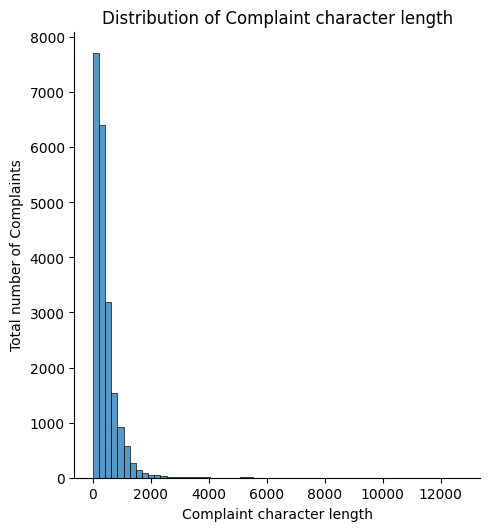

In [25]:
# Write your code here to visualise the data according to the 'Complaint' character length
char_len = [len(each_sent) for each_sent in df_clean['complaint_POS_removed']]

sns.displot(char_len, kind='hist', bins=60)
plt.xlabel("Complaint character length")
plt.ylabel("Total number of Complaints")
plt.title("Distribution of Complaint character length")
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

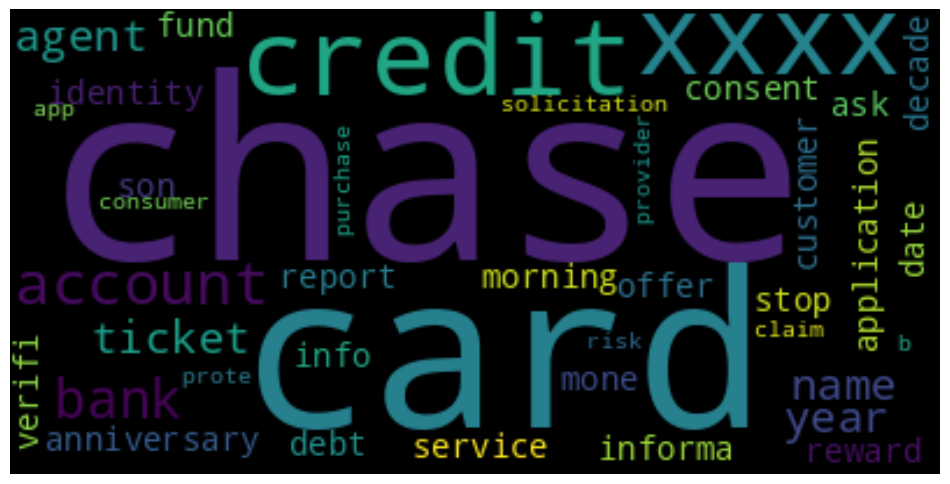

In [26]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text

wordcloud = WordCloud(max_words=40, random_state=1, stopwords=set(STOPWORDS))
wordcloud.generate(str(df_clean['complaint_POS_removed']))
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [27]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [28]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_ngrams(text, n=None, ngram=(1,1)):
  vec = CountVectorizer(stop_words='english', ngram_range=ngram).fit(text)
  bagofwords = vec.transform(text)
  sum_words = bagofwords.sum(axis=0)
  words_frequency = [(word, sum_words[0, index]) for word, index in vec.vocabulary_.items()]
  words_frequency = sorted(words_frequency, key = lambda x: x[1], reverse=True)
  return words_frequency[:n]

In [29]:
top_30words = get_top_ngrams(df_clean['Complaint_clean'].values.astype('U'), n=30, ngram=(1,1))
df_unigram = pd.DataFrame(top_30words, columns=['unigram', 'count'])
df_unigram

,unigram,count
0,chase,52752
1,xxxx,48210
2,account,46738
3,credit,33476
4,card,30226
5,bank,21609
6,payment,21163
7,time,16014
8,charge,14155
9,xxxxxxxx,13582


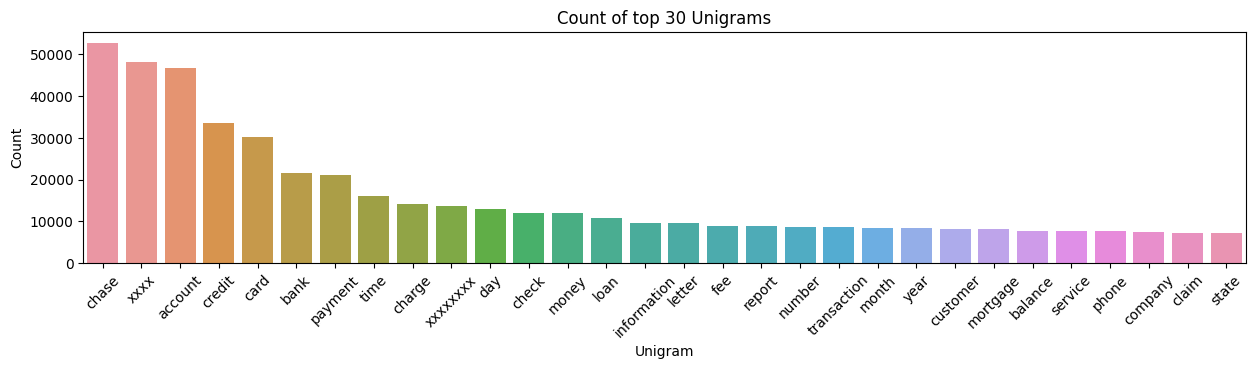

In [30]:
# Plotting top 30 Unigrams

plt.figure(figsize=[15,3])
sns.barplot(x=df_unigram['unigram'], y=df_unigram['count'])
plt.xticks(rotation=45)
plt.xlabel("Unigram")
plt.ylabel("Count")
plt.title("Count of top 30 Unigrams")
plt.show()

In [31]:
#Print the top 10 words in the unigram frequency
df_unigram.head(10)

,unigram,count
0,chase,52752
1,xxxx,48210
2,account,46738
3,credit,33476
4,card,30226
5,bank,21609
6,payment,21163
7,time,16014
8,charge,14155
9,xxxxxxxx,13582


In [32]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
top_30words = get_top_ngrams(df_clean['Complaint_clean'].values.astype('U'), n=30, ngram=(2,2))
df_bigram = pd.DataFrame(top_30words, columns=['bigram', 'count'])
df_bigram

,bigram,count
0,credit card,12853
1,xxxx xxxx,5240
2,credit report,3931
3,customer service,3058
4,account chase,2939
5,chase credit,2827
6,chase account,2601
7,bank account,2437
8,check account,2293
9,account account,2254


In [33]:
#Print the top 10 words in the bigram frequency
df_bigram.head(10)

,bigram,count
0,credit card,12853
1,xxxx xxxx,5240
2,credit report,3931
3,customer service,3058
4,account chase,2939
5,chase credit,2827
6,chase account,2601
7,bank account,2437
8,check account,2293
9,account account,2254


In [34]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
top_30words = get_top_ngrams(df_clean['Complaint_clean'].values.astype('U'), n=30, ngram=(3,3))
df_trigram = pd.DataFrame(top_30words, columns=['trigram', 'count'])
df_trigram

,trigram,count
0,chase credit card,1890
1,credit card account,1090
2,credit card company,989
3,xxxx xxxx xxxx,849
4,xxxx credit card,810
5,credit card chase,712
6,credit card credit,512
7,inquiry credit report,490
8,credit card xxxx,430
9,account credit card,410


In [35]:
#Print the top 10 words in the trigram frequency
df_trigram.head(10)

,trigram,count
0,chase credit card,1890
1,credit card account,1090
2,credit card company,989
3,xxxx xxxx xxxx,849
4,xxxx credit card,810
5,credit card chase,712
6,credit card credit,512
7,inquiry credit report,490
8,credit card xxxx,430
9,account credit card,410


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [36]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [37]:
#All masked texts has been removed
df_clean

,complaints,lemmatized_texts,complaint_POS_removed,Complaint_clean
0,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank service ask debt verifi...,morning name stop bank service ask debt verifi...
1,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,xxxx card agent anniversary date agent informa...,card agent anniversary date agent information...
2,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,chase card report application identity consent...,chase card report application identity consent...
3,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,xxxx xxxx ticket offer ticket reward card info...,ticket offer ticket reward card information ...
4,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...
...,...,...,...,...
21063,after being a chase card customer for well ove...,after be a chase card customer for well over a...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...
21064,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...,xxxx credit card provider claim purchase prote...,credit card provider claim purchase protectio...
21065,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,xxxx risk consumer chase bank app chase year b...,risk consumer chase bank app chase year banki...
21066,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yrs I ve hav...,credit yrs chase credit card chase freedom pro...,credit yrs chase credit card chase freedom pro...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [38]:
#Write your code here to initialise the TfidfVectorizer 

tfidf = TfidfVectorizer(min_df=2, max_df=0.95, stop_words='english')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [39]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = tfidf.fit_transform(df_clean['Complaint_clean'])

In [40]:
dtm

<21068x6780 sparse matrix of type '<class 'numpy.float64'>'
	with 607922 stored elements in Compressed Sparse Row format>

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [41]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [42]:
#Load your nmf_model with the n_components i.e 5
num_topics =5 #write the value you want to test out

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40)#write your code here

In [43]:
nmf_model.fit(dtm)
len(tfidf.get_feature_names_out())

6780

In [44]:
H = nmf_model.components_       # Topic-term matrix

In [45]:
#Print the Top15 words for each of the topics
words = np.array(tfidf.get_feature_names_out())
topic_words = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)
for i in range(num_topics):
    ix = H[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]

topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,check,bank,money,fund,chase,deposit,branch,day,checking,number,business,transfer,transaction,customer
Topic 2,card,credit,chase,balance,account,limit,score,year,point,month,purchase,offer,application,service,time
Topic 3,payment,loan,mortgage,chase,home,month,modification,time,year,rate,property,balance,statement,date,letter
Topic 4,report,inquiry,credit,company,information,reporting,debt,identity,account,theft,score,letter,date,file,creditor
Topic 5,charge,dispute,transaction,chase,fee,merchant,claim,fraud,purchase,service,email,refund,time,company,day


In [46]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic_results = nmf_model.transform(dtm)

In [47]:
#Assign the best topic to each of the cmplaints in Topic Column
df_clean['Topic'] =  topic_results.argmax(axis=1)#write your code to assign topics to each rows.

In [48]:
df_clean.head()

,complaints,lemmatized_texts,complaint_POS_removed,Complaint_clean,Topic
0,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank service ask debt verifi...,morning name stop bank service ask debt verifi...,0
1,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,xxxx card agent anniversary date agent informa...,card agent anniversary date agent information...,1
2,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,chase card report application identity consent...,chase card report application identity consent...,3
3,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,xxxx xxxx ticket offer ticket reward card info...,ticket offer ticket reward card information ...,3
4,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...,0


In [49]:
#Print the first 5 Complaint for each of the Topics
df_clean=df_clean.groupby('Topic').head(5)
df_clean.sort_values('Topic')

,complaints,lemmatized_texts,complaint_POS_removed,Complaint_clean,Topic
0,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank service ask debt verifi...,morning name stop bank service ask debt verifi...,0
10,mishandling of this account by chase auto and ...,mishandle of this account by chase auto and xxxx,mishandle account chase auto xxxx,mishandle account chase auto,0
6,with out notice jp morgan chase restricted my ...,with out notice jp morgan chase restrict my ac...,notice account debit card branch customer serv...,notice account debit card branch customer serv...,0
4,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...,0
12,i opened an account with chase bank on xxxx an...,I open an account with chase bank on xxxx and ...,account bank code bonus xxxxxxxx term everythi...,account bank code bonus term everything accou...,0
14,my chase amazon card was declined for a cateri...,my chase amazon card be decline for a catering...,chase card decline catering order place brothe...,chase card decline catering order place brothe...,1
25,i currently have over xxxx chase ultimate rewa...,I currently have over xxxx chase ultimate rewa...,chase reward point month reward account bonus ...,chase reward point month reward account bonus ...,1
22,my roommate was stealing my chase debit card a...,my roommate be steal my chase debit card and d...,roommate chase debit card driver license money...,roommate chase debit card driver license money...,1
1,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,xxxx card agent anniversary date agent informa...,card agent anniversary date agent information...,1
21,i am a senior citizen that has been scammed by...,I be a senior citizen that have be scamme by s...,citizen company time share company nothing ref...,citizen company time share company nothing ref...,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [50]:
#Create the dictionary of Topic names and Topics
Topic_names = { 0:"Bank account services", 1:"Credit card / Prepaid card", 2:"Others",
               3:"Theft/Dispute reporting", 4:"Mortgages/loans" }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

<ipython-input-50-c0b2ea74aa91>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [51]:
df_clean

,complaints,lemmatized_texts,complaint_POS_removed,Complaint_clean,Topic
0,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank service ask debt verifi...,morning name stop bank service ask debt verifi...,Bank account services
1,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,xxxx card agent anniversary date agent informa...,card agent anniversary date agent information...,Credit card / Prepaid card
2,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,chase card report application identity consent...,chase card report application identity consent...,Theft/Dispute reporting
3,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,xxxx xxxx ticket offer ticket reward card info...,ticket offer ticket reward card information ...,Theft/Dispute reporting
4,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...,Bank account services
5,can you please remove inquiry,can you please remove inquiry,inquiry,inquiry,Theft/Dispute reporting
6,with out notice jp morgan chase restricted my ...,with out notice jp morgan chase restrict my ac...,notice account debit card branch customer serv...,notice account debit card branch customer serv...,Bank account services
7,during the summer months i experience a declin...,during the summer month I experience a decline...,summer month decline income employment month p...,summer month decline income employment month p...,Others
8,on xxxx i made a payment to an online retail...,on xxxx I make a payment to an online reta...,payment retailer chase pay xxxx chase website ...,payment retailer chase pay chase website scam...,Mortgages/loans
9,i have a chase credit card which is incorrectl...,I have a chase credit card which be incorrectl...,credit card datum credit report company issue,credit card datum credit report company issue,Theft/Dispute reporting


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [52]:
#Create the dictionary again of Topic names and Topics

Topic_names = { "Bank account services":0, "Credit card / Prepaid card":1, "Others":2,
               "Theft/Dispute reporting":3, "Mortgages/loans":4 }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

<ipython-input-52-b8ed7048efb3>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [53]:
df_clean

,complaints,lemmatized_texts,complaint_POS_removed,Complaint_clean,Topic
0,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank service ask debt verifi...,morning name stop bank service ask debt verifi...,0
1,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,xxxx card agent anniversary date agent informa...,card agent anniversary date agent information...,1
2,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,chase card report application identity consent...,chase card report application identity consent...,3
3,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,xxxx xxxx ticket offer ticket reward card info...,ticket offer ticket reward card information ...,3
4,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...,0
5,can you please remove inquiry,can you please remove inquiry,inquiry,inquiry,3
6,with out notice jp morgan chase restricted my ...,with out notice jp morgan chase restrict my ac...,notice account debit card branch customer serv...,notice account debit card branch customer serv...,0
7,during the summer months i experience a declin...,during the summer month I experience a decline...,summer month decline income employment month p...,summer month decline income employment month p...,2
8,on xxxx i made a payment to an online retail...,on xxxx I make a payment to an online reta...,payment retailer chase pay xxxx chase website ...,payment retailer chase pay chase website scam...,4
9,i have a chase credit card which is incorrectl...,I have a chase credit card which be incorrectl...,credit card datum credit report company issue,credit card datum credit report company issue,3


In [54]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data= df_clean[['complaints', 'Topic']]

In [55]:
training_data

,complaints,Topic
0,good morning my name is xxxx xxxx and i apprec...,0
1,i upgraded my xxxx xxxx card in and was told ...,1
2,chase card was reported on however fraudulent...,3
3,on while trying to book a xxxx xxxx ticket ...,3
4,my grand son give me check for i deposit it i...,0
5,can you please remove inquiry,3
6,with out notice jp morgan chase restricted my ...,0
7,during the summer months i experience a declin...,2
8,on xxxx i made a payment to an online retail...,4
9,i have a chase credit card which is incorrectl...,3


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [56]:

#Write your code to get the Vector count
vect = CountVectorizer()
X_train_cnt = vect.fit_transform(training_data['complaints'])

#Write your code here to transform the word vector to tf-idf

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_cnt)

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

#### Logistic Regression

In [57]:
# Write your code here to build any 3 models and evaluate them using the required metrics

# Importing LogisticRegression from sklearn
from sklearn.linear_model import LogisticRegression
# Importing Train, Test Split
from sklearn.model_selection import train_test_split

In [58]:
# Train, Test Split
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data['Topic'], test_size=0.25, random_state=42)

In [59]:
logreg = LogisticRegression(random_state=42, solver='liblinear').fit(X_train, y_train)

In [60]:
y_test

8     4
19    4
0     0
30    2
11    3
9     3
13    4
Name: Topic, dtype: int64

In [61]:
X_test_pred=logreg.predict(X_test)
X_test_pred,y_test

(array([1, 1, 1, 1, 1, 1, 1]),
 8     4
 19    4
 0     0
 30    2
 11    3
 9     3
 13    4
 Name: Topic, dtype: int64)

In [62]:
# Getting the score of the base model
logreg.score(X_test, y_test)

0.0

In [63]:
# Setup grid hyperparameter search for LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

logreg_grid = {"C": [100, 10, 5, 4, 3, 2, 1, 1.0, 0.1, 0.01],
                "solver": ["liblinear"]}

logreg_hpt = GridSearchCV(LogisticRegression(random_state=42),
                                param_grid=logreg_grid,
                                cv=5,
                                verbose=True,
                                n_jobs=-1)

# Fit random hyperparameter search model
logreg_hpt.fit(X_train, y_train);

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_split.py:700: UserWarning:

The least populated class in y has only 2 members, which is less than n_splits=5.



In [64]:
logreg_hpt.best_params_


{'C': 100, 'solver': 'liblinear'}

In [65]:
logreg_hpt.score(X_test, y_test)


0.2857142857142857

In [66]:
from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(y_test, X_test_pred))

[[0 1 0 0 0]
 [0 0 0 0 0]
 [0 1 0 0 0]
 [0 2 0 0 0]
 [0 3 0 0 0]]


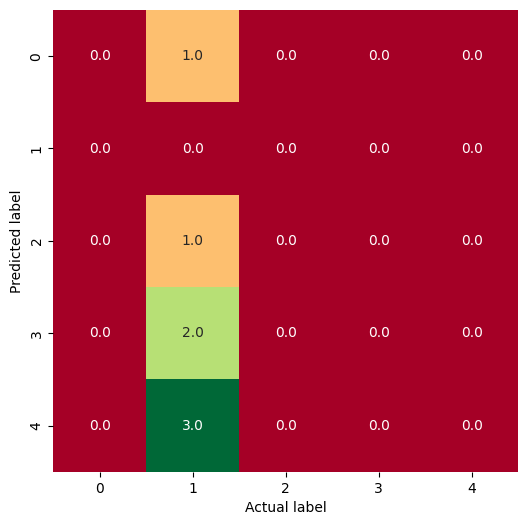

In [67]:
# Visualize Confusion Matrix with heatmap
fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.heatmap(confusion_matrix(y_test, X_test_pred),
                 annot=True,
                 cbar=False,
                 cmap="RdYlGn", fmt = '0.1f')
plt.xlabel("Actual label")
plt.ylabel("Predicted label")
plt.show()

In [68]:
Topicnames_target = ["Bank account services", "Credit card / Prepaid card", "Others", "Theft/Dispute reporting", "Mortgages/loans"]

In [69]:
print(classification_report(y_test, X_test_pred, target_names = Topicnames_target))


                            precision    recall  f1-score   support

     Bank account services       0.00      0.00      0.00       1.0
Credit card / Prepaid card       0.00      0.00      0.00       0.0
                    Others       0.00      0.00      0.00       1.0
   Theft/Dispute reporting       0.00      0.00      0.00       2.0
           Mortgages/loans       0.00      0.00      0.00       3.0

                  accuracy                           0.00       7.0
                 macro avg       0.00      0.00      0.00       7.0
              weighted avg       0.00      0.00      0.00       7.0



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control 

In [70]:
from sklearn.tree import DecisionTreeClassifier


In [71]:
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data['Topic'], test_size=0.25, random_state=42)


In [72]:
dt = DecisionTreeClassifier(random_state=42).fit(X_train, y_train)


In [73]:
dt.score(X_test, y_test)


0.14285714285714285